# Multiclass Classification of IRT Defects using SDCNN
This notebook performs multiclass classification using a custom SDCNN to classify IRT images into four defect classes: PatchWork, Block, Shading, and Single.

In [1]:
# --- Import Libraries ---
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.utils.class_weight import compute_class_weight
import shutil
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pandas as pd
import io
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import io
import random
#from tensorflow_addons.losses import SigmoidFocalCrossEntropy

In [2]:
# --- Setup ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 2

In [3]:
# --- Define Data Paths ---
original_data_dir = '/Users/reamy/Desktop/THESIS/MC_dataset copy 2'  
# original_data_dir/
#   ├── PatchWork/
#   ├── Block/
#   ├── Shading/
#   └── Single/
base_dir = 'data/processed1'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val') 




In [4]:
# Create directories
for split in ['train', 'val']:
    for cls in ['PatchWork', 'Block']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Split and copy images
for cls in ['PatchWork', 'Block']:
    cls_dir = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_dir)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
    for img in val_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))


In [5]:
# --- Data Generators ---
datagen =ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')


train_gen = datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Class mapping:", train_gen.class_indices)

Found 83 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Class mapping: {'Block': 0, 'PatchWork': 1}


In [6]:
# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    #tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    #tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
model.compile(optimizer='adamW',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001)
model.summary()

# Capture the model summary output
summary_output = io.StringIO()
model.summary(print_fn=lambda x: summary_output.write(x + "\n"))
summary_text = summary_output.getvalue()

# Save the summary to a text file
summary_file_path = os.path.join(os.getcwd(), 'model_summary.txt')
with open(summary_file_path, 'w') as f:
    f.write(summary_text)

print(f"Model summary saved to {summary_file_path}")

/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Model summary saved to /Users/reamy/Desktop/THESIS/SDCNN_MC/model_summary.txt


In [7]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

# Save the best model only
checkpoint = ModelCheckpoint(
    filepath='best_SDCNN_MC_model.h5',          # file to save the best model
    monitor='val_loss',                # metric to monitor
    save_best_only=True,               # save only if it's the best so far
    mode='min',                        # because we want to minimize loss
    verbose=1                          # print when saving
)

In [8]:
# --- Custom Callback to Track Metrics ---
val_labels = np.concatenate([val_gen[i][1] for i in range(len(val_gen))])
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_gen, val_labels):
        self.val_generator = val_gen
        self.val_labels = val_labels.reshape(-1).astype(int)
        self.results = []

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = model.predict(self.val_generator)
        val_predictions = (val_predictions > 0.5).astype(int).reshape(-1)

        precision = precision_score(self.val_labels, val_predictions)
        recall = recall_score(self.val_labels, val_predictions)
        f1 = f1_score(self.val_labels, val_predictions)

        self.results.append({
            'Epoch': epoch + 1,
            'Training Accuracy': logs['accuracy'],
            'Validation Accuracy': logs['val_accuracy'],
            'Training Loss': logs['loss'],
            'Validation Loss': logs['val_loss'],
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        print(f"Epoch {epoch + 1}: Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

metrics_callback = MetricsCallback(val_gen, val_labels)

In [9]:
# --- Training the Model ---

class_weights = compute_class_weight('balanced',
                                     classes=np.unique(train_gen.classes),
                                     y=train_gen.classes)
#starting timer
start_time=time.time()
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[metrics_callback,early_stop,checkpoint],class_weight=dict(enumerate(class_weights)))
# End timer
end_time = time.time()
# Calculate and print elapsed time
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds ({elapsed_time / 60:.2f} minutes).")

/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.4206 - auc: 0.4568 - loss: 3.4187 - precision: 0.4206 - recall: 0.42
Epoch 1: Precision=0.3214, Recall=0.3214, F1 Score=0.3214

Epoch 1: val_loss improved from inf to 1.07658, saving model to best_SDCNN_MC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4239 - auc: 0.4632 - loss: 3.6262 - precision: 0.4239 - recall: 0.4239 - val_accuracy: 0.3214 - val_auc: 0.4936 - val_loss: 1.0766 - val_precision: 0.3214 - val_recall: 0.3214
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5030 - auc: 0.5228 - loss: 0.8046 - precision: 0.5030 - recall: 0.50
Epoch 2: Precision=0.6071, Recall=0.6071, F1 Score=0.6071

Epoch 2: val_loss improved from 1.07658 to 0.59649, saving model to best_SDCNN_MC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 847ms/step - accuracy: 0.5128 - auc: 0.5369 - loss: 0.8082 - precision: 0.5128 - recall: 0.5128 - val_accuracy: 0.7500 - val_auc: 0.8788 - val_loss: 0.5965 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6074 - auc: 0.6944 - loss: 0.6654 - precision: 0.6074 - recall: 0.60
Epoch 3: Precision=0.6071, Recall=0.6071, F1 Score=0.6071

Epoch 3: val_loss improved from 0.59649 to 0.40959, saving model to best_SDCNN_MC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 983ms/step - accuracy: 0.5881 - auc: 0.6747 - loss: 0.6623 - precision: 0.5881 - recall: 0.5881 - val_accuracy: 0.7500 - val_auc: 0.9069 - val_loss: 0.4096 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7963 - auc: 0.8828 - loss: 0.4957 - precision: 0.7963 - recall: 0.79
Epoch 4: Precision=0.4643, Recall=0.4643, F1 Score=0.4643

Epoch 4: val_loss did not improve from 0.40959
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 839ms/step - accuracy: 0.7960 - auc: 0.8835 - loss: 0.4917 - precision: 0.7960 - recall: 0.7960 - val_accuracy: 0.7500 - val_auc: 0.9094 - val_loss: 0.4256 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8725 - auc: 0.9668 - loss: 0.3195 - precision: 0.8725 - recall: 0.87
Epoch 5: Precision=0.6429, Recall=0.6429, F1 Score=0.6429

Epoch 5: val_loss improved from 0.40959 to 0.16526, saving model to best_SDCNN_MC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 945ms/step - accuracy: 0.8712 - auc: 0.9661 - loss: 0.3146 - precision: 0.8712 - recall: 0.8712 - val_accuracy: 0.9286 - val_auc: 0.9898 - val_loss: 0.1653 - val_precision: 0.9286 - val_recall: 0.9286
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.8549 - auc: 0.9233 - loss: 0.3933 - precision: 0.8549 - recall: 0.85
Epoch 6: Precision=0.4286, Recall=0.4286, F1 Score=0.4286

Epoch 6: val_loss did not improve from 0.16526
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 936ms/step - accuracy: 0.8611 - auc: 0.9279 - loss: 0.3727 - precision: 0.8611 - recall: 0.8611 - val_accuracy: 0.8571 - val_auc: 0.9745 - val_loss: 0.2307 - val_precision: 0.8571 - val_recall: 0.8571
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9024 - auc: 0.9504 - loss: 0.2842 - precision: 0.9024 - recall: 0.90
Epoch 7: Precision=0.6071, Recall=0.6071, F1 Score=0.6071

Epoch 7: val_loss did not improve from 0.16526
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 839ms/step - accuracy: 0.8967 - auc:

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 883ms/step - accuracy: 0.7977 - auc: 0.8779 - loss: 0.4874 - precision: 0.7977 - recall: 0.7977 - val_accuracy: 0.9643 - val_auc: 0.9936 - val_loss: 0.1527 - val_precision: 0.9643 - val_recall: 0.9643
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8775 - auc: 0.9439 - loss: 0.2993 - precision: 0.8775 - recall: 0.87
Epoch 10: Precision=0.4286, Recall=0.4286, F1 Score=0.4286

Epoch 10: val_loss did not improve from 0.15270
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 927ms/step - accuracy: 0.8720 - auc: 0.9395 - loss: 0.3038 - precision: 0.8720 - recall: 0.8720 - val_accuracy: 0.7143 - val_auc: 0.8329 - val_loss: 0.5677 - val_precision: 0.7143 - val_recall: 0.7143
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8886 - auc: 0.9619 - loss: 0.2352 - precision: 0.8886 - recall: 0.88
Epoch 11: Precision=0.5714, Recall=0.5714, F1 Score=0.5714

Epoch 11: val_loss did not improve from 0.15270
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 825ms/step - accuracy: 0.8953 

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 834ms/step - accuracy: 0.8989 - auc: 0.9666 - loss: 0.2384 - precision: 0.8989 - recall: 0.8989 - val_accuracy: 0.9643 - val_auc: 0.9987 - val_loss: 0.1358 - val_precision: 0.9643 - val_recall: 0.9643
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9614 - auc: 0.9892 - loss: 0.1278 - precision: 0.9614 - recall: 0.96
Epoch 15: Precision=0.5000, Recall=0.5000, F1 Score=0.5000

Epoch 15: val_loss did not improve from 0.13576
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 999ms/step - accuracy: 0.9650 - auc: 0.9906 - loss: 0.1215 - precision: 0.9650 - recall: 0.9650 - val_accuracy: 0.7500 - val_auc: 0.9031 - val_loss: 0.4294 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9549 - auc: 0.9882 - loss: 0.1378 - precision: 0.9549 - recall: 0.95
Epoch 16: Precision=0.4286, Recall=0.4286, F1 Score=0.4286

Epoch 16: val_loss did not improve from 0.13576
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 800ms/step - accuracy: 0.9451 

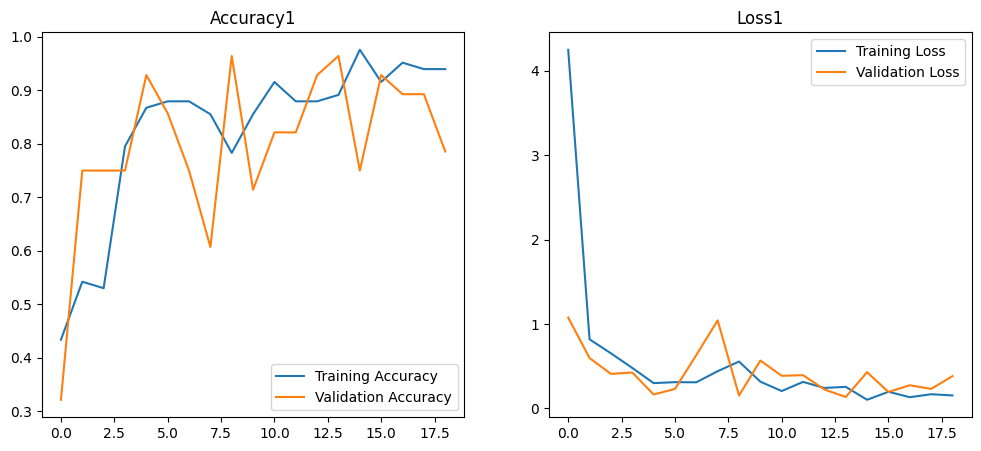

In [10]:
# --- Plot Training Curves ---
def plot_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy1')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss1')

    plt.show()

plot_history(history)

In [11]:
# --- Save Metrics to CSV ---
results_df1 = pd.DataFrame(metrics_callback.results)
results_file_path = os.path.join(os.getcwd(), 'training_results1.csv')
results_df1.to_csv(results_file_path, index=False)
print(f"Training results saved to {results_file_path}")

# --- Plotting Metrics ---
metrics = ['Precision', 'Recall', 'F1 Score', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
titles = ['Precision1', 'Recall1', 'F1 Score1', 'Training Accuracy1', 'Validation Accuracy1', 'Training Loss1', 'Validation Loss1']
file_names = ['precision_plot1.png', 'recall_plot1.png', 'f1_score_plot1.png',
              'training_accuracy_plo1t.png', 'validation_accuracy_plot1.png',
              'training_loss_plot1.png', 'validation_loss_plot1.png']

for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 5))
    plt.plot(results_df1[metric], label=metric, linewidth=2, color='red')
    plt.title(titles[i], fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    # Annotate last value
    last_epoch = len(results_df1[metric]) - 1
    last_value = results_df1[metric].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value + 0.02),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

    plt.tight_layout()
    plt.savefig(file_names[i], dpi=300)
    plt.close()

print("All plots saved successfully.")

Training results saved to /Users/reamy/Desktop/THESIS/SDCNN_MC/training_results1.csv
All plots saved successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Classification Report:
              precision    recall  f1-score   support

       Block       0.38      0.33      0.35         9
   PatchWork       0.70      0.74      0.72        19

    accuracy                           0.61        28
   macro avg       0.54      0.54      0.54        28
weighted avg       0.60      0.61      0.60        28



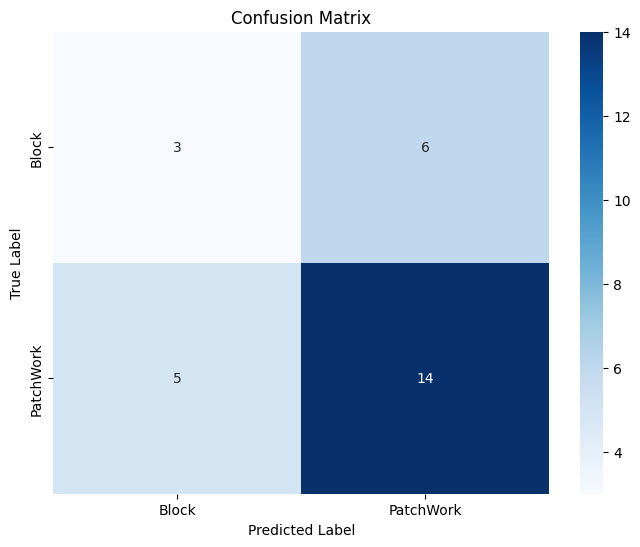

In [12]:
# --- Evaluation ---
val_gen.reset()
predictions = model.predict(val_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [ ]:
report_dict = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
class_results = pd.DataFrame(report_dict).transpose()

# (Optional) Save to CSV
class_results.to_csv("classification_report.csv")

# Show preview
print(class_results)

In [ ]:
# --- Save Model ---
model.save('SDCNN_MC_model1.h5')

In [ ]:


# Get a batch of images and labels
images, labels = next(val_gen)

# Number of images to display
N = 5

# Randomly choose N indices from the batch
indices = random.sample(range(images.shape[0]), N)

# Get class labels
class_labels = list(val_gen.class_indices.keys())

# Plot images with predictions
plt.figure(figsize=(15, 5))

for i, idx in enumerate(indices):
    img = images[idx]
    true_label = np.argmax(labels[idx])

    # Predict
    pred = model.predict(img[np.newaxis, ...], verbose=0)
    pred_label = np.argmax(pred)

    # Plot image
    plt.subplot(1, N, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}")

plt.tight_layout()
plt.show()